In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pprint import pprint
import folium
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from collections import Counter
import json


In [2]:
class airbnb_city:
    
    def __init__(self, csv):
        
        self.csv = csv
                
        self.df_city = pd.read_csv(self.csv)
        
        print("Instance created!")
        
    def clean_columns(self):
        
        # Take only the relevant columns in the dataframe
        
        l_relevant_columns = ["host_is_superhost","neighbourhood_cleansed","neighbourhood_group_cleansed","property_type","room_type","accommodates","bathrooms_text","beds","price","minimum_nights","maximum_nights","availability_30","availability_365","number_of_reviews","instant_bookable", "amenities", "host_verifications"]

        self.df_city = self.df_city[l_relevant_columns]
        
        self.df_city["bathrooms_text"].replace(np.nan, "?", inplace = True)
        
        # Get numbers out of bathroom_text columns
        
        l_nums = [re.findall(r'\d+',i) for i in self.df_city["bathrooms_text"].values]

        l_nums_completed = []

        for i in l_nums:

            if len(i) > 1:

                l_nums_completed.append('.'.join(i))

            elif len(i) == 0:

                l_nums_completed.append('0')

            else:

                l_nums_completed.append(i[0])

        # Separate categories from bathroom_text
        
        l_category = []

        for i in self.df_city["bathrooms_text"].values:

            if "shared" in i:

                l_category.append("Shared")

            elif "private" in i:

                l_category.append("Private")

            else:

                l_category.append("Unknown")
                
        # Create two different columns replacing bathroom_text
        
        self.df_city.drop("bathrooms_text", axis = 1, inplace = True)
                
        self.df_city["num_of_baths"] = l_nums_completed
        
        self.df_city["bath_category"] = l_category
        
        self.df_city["num_of_baths"] = self.df_city["num_of_baths"].astype("float64")

        # Column["prices"]
        
        self.df_city["price"]  = self.df_city["price"] .apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x)
        
        self.df_city["amenities"] = [len(i) for i in self.df_city["amenities"]]

        self.df_city["host_verifications"] = [len(i) for i in self.df_city["host_verifications"]]
        
        
        print("Dataframe sucessfully created!")
    
    def label_encoding(self):
        
        self.df_city.dropna(inplace=True)
        
        # Encoding columns with dummies function
        
        def dummies(data, column):
            return pd.get_dummies(data = data[column], drop_first=True)
        
        self.df_city["host_is_superhost"] = dummies(self.df_city, "host_is_superhost")
        self.df_city["instant_bookable"] = dummies(self.df_city, "instant_bookable")
        
        df_room_type = dummies(self.df_city, "room_type")
        df_bath_category = dummies(self.df_city, "bath_category")
        df_bath_category = df_bath_category.rename(columns={'Shared': 'shared_bath', 'Unknown': 'unknoun_bath'})
        
        self.df_city = pd.concat([self.df_city, df_bath_category], axis = 1)

        self.df_city = pd.concat([self.df_city, df_room_type], axis = 1)

        self.df_city.drop("room_type", axis = 1, inplace = True)

        self.df_city.drop("bath_category", axis = 1, inplace = True)
        
        # Encoding categorical columns with labelEncoding function
        
        l_columns_to_labelEncode = ["neighbourhood_cleansed", "property_type", "neighbourhood_group_cleansed"]
        l_columns_encoded = list()

        for i in l_columns_to_labelEncode:

            # Inicializing object LabelEncoder()
            o_labelEncoding = LabelEncoder()

            # Training it with the column data
            o_labelEncoding.fit(self.df_city[i].values)

            # Transform the column
            l_columns_encoded.append(o_labelEncoding.transform(self.df_city[i].values))

        self.df_city["neighbourhood_cleansed"] = l_columns_encoded[0]
        self.df_city["property_type"] = l_columns_encoded[1]
        self.df_city["neighbourhood_group_cleansed"] = l_columns_encoded[2]
        
        print("Dataframe sucessfully encoded!")

        
    def return_df(self):
    
        return self.df_city
    
    def display_df(self):
    
        display(self.df_city)

In [3]:
madrid = airbnb_city("datasets/Madrid air bnb/listings_detailed.csv")

Instance created!


In [4]:
df = madrid.return_df()

# Markdown reserved

In [5]:
df_columns_chosen = df[["minimum_nights", "property_type", "room_type", "neighbourhood_group_cleansed","latitude", "longitude", "number_of_reviews", "price","reviews_per_month","beds","calculated_host_listings_count", "accommodates"]]

In [6]:
df_columns_chosen

,minimum_nights,property_type,room_type,neighbourhood_group_cleansed,latitude,longitude,number_of_reviews,price,reviews_per_month,beds,calculated_host_listings_count,accommodates
0,1,Private room in apartment,Private room,Chamartín,40.45724,-3.67688,78,$60.00,0.58,1.0,1,2
1,4,Private room in apartment,Private room,Latina,40.40381,-3.74130,33,$31.00,0.42,1.0,2,1
2,15,Entire apartment,Entire home/apt,Arganzuela,40.38840,-3.69511,0,$50.00,NaN,5.0,7,6
3,5,Entire apartment,Entire home/apt,Centro,40.42183,-3.70529,10,$92.00,0.13,1.0,1,3
4,2,Private room in house,Private room,Arganzuela,40.38975,-3.69018,149,$26.00,1.12,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19613,30,Private room in apartment,Private room,Centro,40.40756,-3.69937,0,$23.00,NaN,1.0,8,1
19614,30,Private room in apartment,Private room,Chamberí,40.43706,-3.71364,0,$21.00,NaN,1.0,8,1
19615,7,Private room in apartment,Private room,Chamberí,40.43857,-3.70715,0,$22.00,NaN,1.0,8,1
19616,30,Private room in apartment,Private room,Salamanca,40.43027,-3.66759,0,$19.00,NaN,1.0,8,1


In [7]:
df_columns_chosen = df_columns_chosen.dropna()

In [8]:
df_columns_chosen.reset_index(drop = True, inplace = True)

In [9]:
df_columns_chosen["price"] = df_columns_chosen["price"].apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x).values

/var/folders/10/5nbnv2696vlgb605wf3g6wwh0000gn/T/ipykernel_1146/1023210409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen["price"] = df_columns_chosen["price"].apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x).values


In [10]:
# len(json.loads(df["amenities"].values[0]))

In [11]:
# for enum, i in enumerate(df["amenities"].values):
    
#     df_columns_chosen["amenities"].values[enum] = json.load(i)

In [12]:
# a = df_columns_chosen["amenities"].explode()
# a[:] = a.factorize()[0]
# df_columns_chosen['amenities'] = a.groupby(level=0).agg(list)

In [13]:
dict_property_types = dict(Counter(df_columns_chosen["property_type"]))

list_others = []
for i in dict_property_types.keys():
    
    if dict_property_types[i] < 300:
        
        list_others.append(i)
        
for i in list_others:
    
    df_columns_chosen["property_type"].replace(i,"Other", inplace = True)

/var/folders/10/5nbnv2696vlgb605wf3g6wwh0000gn/T/ipykernel_1146/1162521284.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen["property_type"].replace(i,"Other", inplace = True)


In [14]:
Counter(df_columns_chosen["property_type"])

Counter({'Private room in apartment': 3784,
         'Entire apartment': 7508,
         'Private room in house': 472,
         'Entire loft': 498,
         'Other': 1602})

In [15]:
df_columns_chosen

,minimum_nights,property_type,room_type,neighbourhood_group_cleansed,latitude,longitude,number_of_reviews,price,reviews_per_month,beds,calculated_host_listings_count,accommodates
0,1,Private room in apartment,Private room,Chamartín,40.45724,-3.67688,78,60.0,0.58,1.0,1,2
1,4,Private room in apartment,Private room,Latina,40.40381,-3.74130,33,31.0,0.42,1.0,2,1
2,5,Entire apartment,Entire home/apt,Centro,40.42183,-3.70529,10,92.0,0.13,1.0,1,3
3,2,Private room in house,Private room,Arganzuela,40.38975,-3.69018,149,26.0,1.12,1.0,1,1
4,1,Entire apartment,Entire home/apt,Arganzuela,40.38860,-3.69492,3,85.0,0.03,4.0,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...
13859,1,Other,Private room,Tetuán,40.46816,-3.68873,1,25.0,1.00,1.0,1,2
13860,2,Entire apartment,Entire home/apt,Centro,40.42207,-3.69930,1,44.0,1.00,1.0,2,4
13861,2,Entire apartment,Entire home/apt,Centro,40.42059,-3.70338,1,37.0,1.00,1.0,1,2
13862,1,Entire apartment,Entire home/apt,Ciudad Lineal,40.43080,-3.65934,1,70.0,1.00,2.0,1,3


In [16]:
l_lbencode = ["property_type","neighbourhood_group_cleansed"]
for i in l_lbencode:

    # Inicializing object LabelEncoder()
    o_labelEncoding = LabelEncoder()

    # Training it with the column data
    o_labelEncoding.fit(df_columns_chosen[i].values)

    # Transform the column
    df_columns_chosen[i] = o_labelEncoding.transform(df_columns_chosen[i].values)

/var/folders/10/5nbnv2696vlgb605wf3g6wwh0000gn/T/ipykernel_1146/3187413224.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen[i] = o_labelEncoding.transform(df_columns_chosen[i].values)


In [17]:
df_columns_chosen

,minimum_nights,property_type,room_type,neighbourhood_group_cleansed,latitude,longitude,number_of_reviews,price,reviews_per_month,beds,calculated_host_listings_count,accommodates
0,1,3,Private room,4,40.45724,-3.67688,78,60.0,0.58,1.0,1,2
1,4,3,Private room,9,40.40381,-3.74130,33,31.0,0.42,1.0,2,1
2,5,0,Entire home/apt,3,40.42183,-3.70529,10,92.0,0.13,1.0,1,3
3,2,4,Private room,0,40.38975,-3.69018,149,26.0,1.12,1.0,1,1
4,1,0,Entire home/apt,0,40.38860,-3.69492,3,85.0,0.03,4.0,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...
13859,1,2,Private room,16,40.46816,-3.68873,1,25.0,1.00,1.0,1,2
13860,2,0,Entire home/apt,3,40.42207,-3.69930,1,44.0,1.00,1.0,2,4
13861,2,0,Entire home/apt,3,40.42059,-3.70338,1,37.0,1.00,1.0,1,2
13862,1,0,Entire home/apt,6,40.43080,-3.65934,1,70.0,1.00,2.0,1,3


In [18]:
df_columns_chosen = df_columns_chosen[df_columns_chosen["price"] < 100]

In [19]:
df_columns_chosen.reset_index(drop=True,inplace=True)

In [20]:
df_columns_chosen

,minimum_nights,property_type,room_type,neighbourhood_group_cleansed,latitude,longitude,number_of_reviews,price,reviews_per_month,beds,calculated_host_listings_count,accommodates
0,1,3,Private room,4,40.45724,-3.67688,78,60.0,0.58,1.0,1,2
1,4,3,Private room,9,40.40381,-3.74130,33,31.0,0.42,1.0,2,1
2,5,0,Entire home/apt,3,40.42183,-3.70529,10,92.0,0.13,1.0,1,3
3,2,4,Private room,0,40.38975,-3.69018,149,26.0,1.12,1.0,1,1
4,1,0,Entire home/apt,0,40.38860,-3.69492,3,85.0,0.03,4.0,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...
10920,1,2,Private room,16,40.46816,-3.68873,1,25.0,1.00,1.0,1,2
10921,2,0,Entire home/apt,3,40.42207,-3.69930,1,44.0,1.00,1.0,2,4
10922,2,0,Entire home/apt,3,40.42059,-3.70338,1,37.0,1.00,1.0,1,2
10923,1,0,Entire home/apt,6,40.43080,-3.65934,1,70.0,1.00,2.0,1,3


/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='accommodates', ylabel='count'>

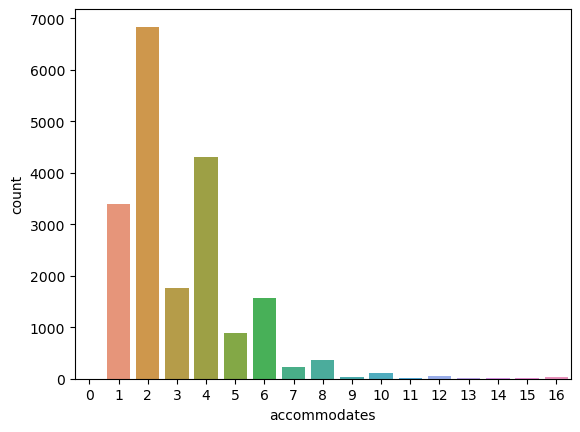

In [21]:
sns.countplot(df["accommodates"])

In [22]:
for i in df["accommodates"].values:
    
    if i > 8:
        
        df["accommodates"].replace(i,9, inplace = True)
        
    elif i == 0:
        
        df["accommodates"].replace(i,1, inplace = True)

        

/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='accommodates', ylabel='count'>

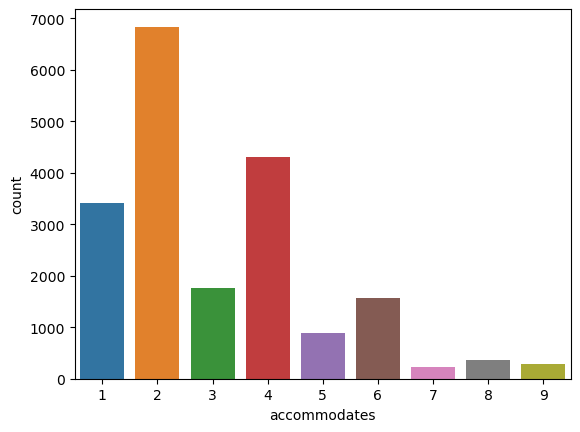

In [23]:
sns.countplot(df["accommodates"])

In [24]:
def dummies(data, column):
    return pd.get_dummies(data = data[column], drop_first=True)

df_room_type = dummies(df_columns_chosen, "room_type")
df_columns_chosen = pd.concat([df_columns_chosen, df_room_type], axis = 1)
df_columns_chosen.drop("room_type", axis = 1, inplace = True)

In [25]:
df_columns_chosen

,minimum_nights,property_type,neighbourhood_group_cleansed,latitude,longitude,number_of_reviews,price,reviews_per_month,beds,calculated_host_listings_count,accommodates,Hotel room,Private room,Shared room
0,1,3,4,40.45724,-3.67688,78,60.0,0.58,1.0,1,2,0,1,0
1,4,3,9,40.40381,-3.74130,33,31.0,0.42,1.0,2,1,0,1,0
2,5,0,3,40.42183,-3.70529,10,92.0,0.13,1.0,1,3,0,0,0
3,2,4,0,40.38975,-3.69018,149,26.0,1.12,1.0,1,1,0,1,0
4,1,0,0,40.38860,-3.69492,3,85.0,0.03,4.0,7,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10920,1,2,16,40.46816,-3.68873,1,25.0,1.00,1.0,1,2,0,1,0
10921,2,0,3,40.42207,-3.69930,1,44.0,1.00,1.0,2,4,0,0,0
10922,2,0,3,40.42059,-3.70338,1,37.0,1.00,1.0,1,2,0,0,0
10923,1,0,6,40.43080,-3.65934,1,70.0,1.00,2.0,1,3,0,0,0


# Getting rid of outliers using quantiles

In [26]:
cols = df_columns_chosen.columns

# cols = cols.tolist()

# cols.remove("amenities")

cols
for col in cols:
    upper_bound = df_columns_chosen[col].quantile(0.95)
    lower_bound = df_columns_chosen[col].quantile(0.05)
    listings = df_columns_chosen[df_columns_chosen[col] < upper_bound]
    listings = df_columns_chosen[df_columns_chosen[col] > lower_bound]

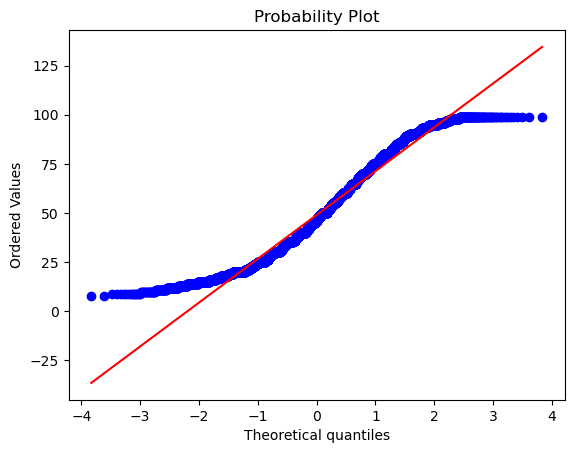

In [27]:
# Plot before transformation
stats.probplot(df_columns_chosen["price"], plot=plt)

# Power Transformer
numeric_cols = list(df_columns_chosen._get_numeric_data().columns)
pt = PowerTransformer(method="yeo-johnson")
df_columns_chosen[numeric_cols] = pt.fit_transform(df_columns_chosen[numeric_cols])

((array([-3.83242186, -3.6084778 , -3.48558668, ...,  3.48558668,
          3.6084778 ,  3.83242186]),
  array([-2.44644407, -2.44644407, -2.33760849, ...,  1.8621538 ,
          1.8621538 ,  1.8621538 ])),
 (0.9890702339969193, 4.1851944343644766e-16, 0.9887435507403224))

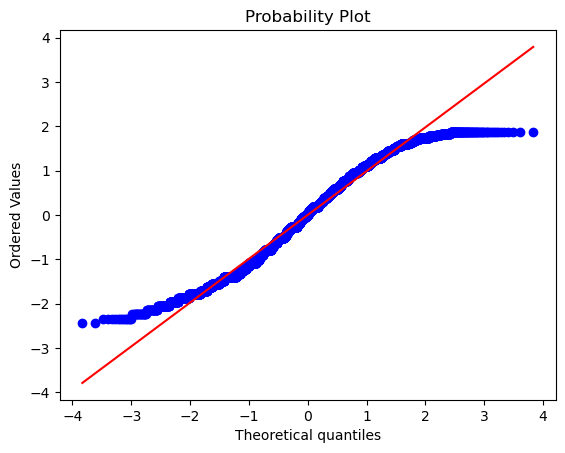

In [28]:
# After transformation
stats.probplot(df_columns_chosen["price"], plot=plt)

## Dividing x & y

In [29]:
X = df_columns_chosen.drop("price", axis = 1)
y = df_columns_chosen[["price"]]

## Scaling data

In [30]:
from sklearn.preprocessing import MinMaxScaler


scaler_x = MinMaxScaler()
scaler_x.fit(X)
X = scaler_x.transform(X)


scaler_y = MinMaxScaler()
scaler_y.fit(y)
y = scaler_y.transform(y)

## Feature importances

In [31]:
df_class = df_columns_chosen["price"].copy()

df_columns_chosen.drop("price", axis = 1, inplace = True)

X = np.asarray(df_columns_chosen)
y = np.asarray(df_class)

In [32]:
X.shape, y.shape

((10925, 13), (10925,))

Feature ranking:
1. feature 11 (0.409969): minimum_nights
2. feature 6 (0.090629): property_type
3. feature 4 (0.084004): neighbourhood_group_cleansed
4. feature 5 (0.068476): latitude
5. feature 8 (0.060735): longitude
6. feature 12 (0.060629): number_of_reviews
7. feature 9 (0.060267): reviews_per_month
8. feature 2 (0.053592): beds
9. feature 0 (0.052391): calculated_host_listings_count
10. feature 7 (0.035501): accommodates
11. feature 1 (0.021943): Hotel room
12. feature 10 (0.001863): Private room
13. feature 3 (0.000000): Shared room


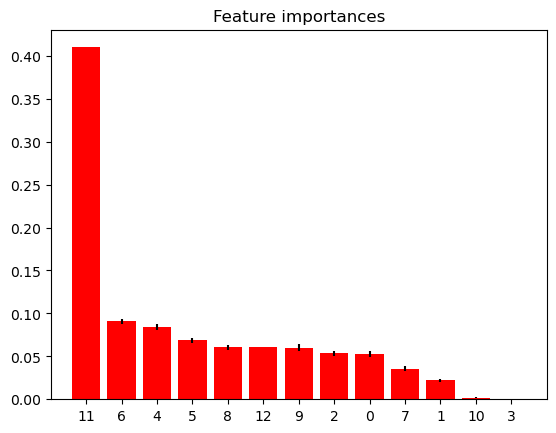

In [33]:
from sklearn.ensemble import ExtraTreesRegressor

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators = 250,
                              random_state = 0)

forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], df_columns_chosen.columns[f]))

# Plot the feature importances of the forest
plt.figure()

plt.title("Feature importances")

plt.bar(range(X.shape[1]), importances[indices], color = "r", yerr = std[indices], align = "center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## 1. LinearRegression

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data: {X_test.shape, y_test.shape}")

Train data: ((9832, 13), (9832,))
Test data: ((1093, 13), (1093,))


In [35]:
# Regresión algorithm

regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train, y_train)

# Finding coef

print ("weights:", regresion_lineal.coef_)
print ("w_0:", regresion_lineal.intercept_)

weights: [-4.33886381e-02 -1.40714501e-02 -7.46832761e-02  1.09182199e+14
  1.12611715e-02  1.28667550e-01 -2.35548525e-01  8.88582449e-03
 -3.22806533e-02  2.99706951e-01 -2.14190744e-02 -4.97929743e-01
 -2.08466249e-01]
w_0: 0.0002439328709546199


## Predicción

In [36]:
yhat = regresion_lineal.predict(X_test)

for i, j in zip(yhat[:5], y_test[:5]):
    print(f"Predicción:{i} \tValor real:{j}")

Predicción:0.21859912340086085 	Valor real:-0.6803771891033201
Predicción:-1.2017229252927355 	Valor real:-1.4111699055750724
Predicción:-0.7586507762427687 	Valor real:-1.7063079347283907
Predicción:-0.603868541758897 	Valor real:-0.4713133702577521
Predicción:0.40570907190617966 	Valor real:-0.043367226397720476


## Metrics

In [37]:
# Sklearn tiene las formulas de algunas métricas en funciones.

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [38]:
# Relative Absolute Error
RAE = np.sum(np.abs(np.subtract(y_test, yhat))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))

# Relative Square Error
RSE = np.sum(np.square(np.subtract(y_test, yhat))) / np.sum(np.square(np.subtract(y_test, np.mean(y_test))))

# Adjusted R**2
r2_ajustada = 1 - (1 - regresion_lineal.score(X_test, y_test))*(len(y_test) - 1)/(len(y_test) - X_test.shape[1] - 1)

In [39]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.5205491192986988
MSE:	 0.42330898090337915
R**2:	 0.22717975056663098
RAE:	 0.627301831809224
RSE:	 0.43538865507576663
Adjusted R**2:	 0.5593656984775374


In [40]:
# Veamos los valores de yhat, y_test y su diferencia

df_pred = pd.DataFrame()

df_pred["y_test"] = scaler_y.inverse_transform([y_test]).flatten()
df_pred["yhat"] = scaler_y.inverse_transform([yhat]).flatten()

df_pred["diferencia"] = round(abs((df_pred["y_test"] - df_pred["yhat"]) / df_pred["y_test"] * 100), 4)

df_pred = df_pred.sort_values("diferencia")

df_pred.head(20)

,y_test,yhat,diferencia
89,-7.941900,-7.927149,0.1857
130,-6.094640,-6.062511,0.5272
775,-5.851428,-5.882464,0.5304
430,-5.147208,-5.174724,0.5346
265,-5.851428,-5.899885,0.8281
131,-6.094640,-6.150430,0.9154
1076,-0.983126,-0.992769,0.9809
566,-7.385148,-7.458724,0.9963
60,-4.477144,-4.534064,1.2714
282,2.496988,2.531883,1.3975


In [41]:
df_pred.tail(20)

,y_test,yhat,diferencia
975,-0.131681,-4.141295,3044.9557
912,0.033761,1.249745,3601.6929
625,-0.131681,-5.249687,3886.6830
294,0.033761,1.349806,3898.0669
252,0.033761,1.473517,4264.4940
44,-0.131681,-5.766015,4278.7899
727,0.033761,1.504149,4355.2253
427,0.033761,1.612575,4676.3786
717,0.033761,1.837835,5343.5901
267,0.033761,-1.883496,5678.8345


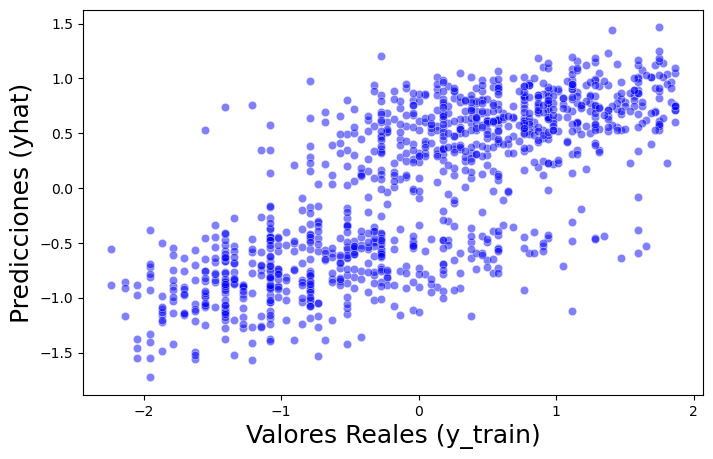

In [42]:
# Distance btw real and predicted values

plt.figure(figsize = (8, 5))

sns.scatterplot(x = y_test.flatten(), y = yhat.flatten(), alpha = 0.5, color = "blue")

plt.xlabel("Valores Reales (y_train)", size = 18)
plt.ylabel("Predicciones (yhat)", size = 18)

plt.show()

# 2. KNeighborsRegressor

In [43]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors = 7)

model.fit(X_train, y_train)

yhat = model.predict(X_test)

yhat

array([-0.07470616, -1.25107405, -1.48395682, ...,  0.88545632,
        0.55313395, -0.81992055])

In [44]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.49906335649144185
MSE:	 0.4158358331416602
R**2:	 0.3272233446910452
RAE:	 0.627301831809224
RSE:	 0.43538865507576663
Adjusted R**2:	 0.5593656984775374


# 3. DecisionTreeRegressor

In [45]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

yhat = model.predict(X_test)

yhat

array([ 1.15849764e-03, -3.22738863e-01,  1.74130606e-01, ...,
        1.86215380e+00,  3.39627516e-01, -1.34081510e-01])

In [46]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.6329675532732546
MSE:	 0.708630284820006
R**2:	 0.30796861234160555
RAE:	 0.627301831809224
RSE:	 0.43538865507576663
Adjusted R**2:	 0.5593656984775374


# 4. RandomForestRegressor

In [47]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs= -1 )
model.fit(X_train, y_train)

yhat = model.predict(X_test)

yhat

array([ 0.04471605, -1.27662144, -1.02398711, ...,  0.6354156 ,
        0.46758556, -0.40567461])

In [48]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")



MAE:	 0.4638785047652008
MSE:	 0.3661204362160836
R**2:	 0.42439332633282434
RAE:	 0.627301831809224
RSE:	 0.43538865507576663
Adjusted R**2:	 0.5593656984775374


# 4. AdaBoostRegressor

In [51]:
%%time 

from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(RandomForestRegressor(n_estimators=200, n_jobs= -1, max_depth=20),
                          n_estimators = 200)
model.fit(X_train, y_train)

yhat = model.predict(X_test)

yhat

array([ 0.13194231, -1.16934553, -1.10075568, ...,  0.69532294,
        0.59207378, -0.3742093 ])

In [52]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.4705244184432226
MSE:	 0.3615366702984346
R**2:	 0.3849558339151429
RAE:	 0.627301831809224
RSE:	 0.43538865507576663
Adjusted R**2:	 0.5593656984775374
